Modelo de lenguaje con tokenización por caracteres
Consigna
Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determinístico y estocástico.

En este último caso (estocástico) observar el efecto de la temperatura en la generación de secuencias.

Sugerencias
Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.

rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [ ]:
import requests
import time

# IDs VERIFICADOS MANUALMENTE - Todos realmente en español
BOOKS_VERIFIED = {
    # --- SIGLO DE ORO (Los que SÍ funcionaron) ---
    2000:  "Don Quijote - Miguel de Cervantes",
    1619:  "Novelas ejemplares - Miguel de Cervantes",
    320:   "Lazarillo de Tormes - Anónimo",
    
    # --- REALISMO Y NATURALISMO (Los que SÍ funcionaron) ---
    17013: "Fortunata y Jacinta - Benito Pérez Galdós",
    17073: "La Regenta - Leopoldo Alas 'Clarín'",
    10814: "Rimas - Gustavo Adolfo Bécquer",
    14765: "El Gaucho Martín Fierro - José Hernández",
    
    # --- ADICIONALES VERIFICADOS EN ESPAÑOL ---
    16298: "El Gaucho Martín Fierro - José Hernández (versión completa)",
    19010: "Platero y yo - Juan Ramón Jiménez",
    49836: "Campos de Castilla - Antonio Machado",
    31786: "Sonatas - Ramón del Valle-Inclán",
    16825: "La tía Tula - Miguel de Unamuno",
    32252: "Niebla - Miguel de Unamuno",
    62967: "Abel Sánchez - Miguel de Unamuno",
    58922: "San Manuel Bueno, mártir - Miguel de Unamuno",
    21730: "El árbol de la ciencia - Pío Baroja",
    15911: "La busca - Pío Baroja",
    
    # --- MÁS GALDÓS (verificados) ---
    16680: "Misericordia - Benito Pérez Galdós",
    31188: "Torquemada en la hoguera - Benito Pérez Galdós",
    
    # --- POESÍA LATINOAMERICANA ---
    12681: "Canto General (fragmentos) - Pablo Neruda",
}
OUTPUT_FILE = "corpus_espanol.txt"
DOWNLOAD_COUNT = 0
TOTAL_SIZE_MB = 0.0

def get_text_content(book_id):
    """Intenta descargar usando una cabecera User-Agent para evitar bloqueos."""
    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    headers = {'User-Agent': 'Mozilla/5.0 (CorpusBot/1.0)'}
    try:
        response = requests.get(url, headers=headers, timeout=20)
        if response.status_code == 200:
            # Forzamos decodificación utf-8, ignorando errores menores
            return response.content.decode('utf-8', errors='ignore')
        return None
    except Exception as e:
        print(f"Error de conexión: {e}")
        return None

def validate_language(text):
    """
    Busca la línea 'Language:' en las primeras 200 líneas del archivo.
    Retorna True si es español o si no encuentra la etiqueta (asume ok).
    Retorna False si explícitamente dice otro idioma.
    """
    lines = text.splitlines()[:200] # Solo miramos el encabezado
    for line in lines:
        if line.strip().startswith("Language:"):
            lang_value = line.split(":", 1)[1].strip().lower()
            if "spanish" in lang_value or "español" in lang_value:
                return True
            else:
                print(f"Se detectó '{lang_value}' en lugar de español.")
                return False
    return True # Si no encuentra la etiqueta, asumimos que está bien por el ID verificado

def clean_content(text):
    """
    Limpieza robusta: busca múltiples variantes de marcadores 
    para eliminar la licencia en inglés (header/footer).
    """
    lines = text.splitlines()
    start_idx = 0
    end_idx = len(lines)

    # Variantes comunes de marcadores de Gutenberg
    start_markers = [
        "*** START OF THE PROJECT", "*** START OF THIS PROJECT", 
        "***START OF THE PROJECT", "***START OF THIS PROJECT",
        "START OF THE PROJECT GUTENBERG", "START OF THIS PROJECT GUTENBERG"
    ]
    end_markers = [
        "*** END OF THE PROJECT", "*** END OF THIS PROJECT", 
        "***END OF THE PROJECT", "***END OF THIS PROJECT",
        "END OF THE PROJECT GUTENBERG"
    ]

    # 1. Buscar marcador de INICIO
    for i, line in enumerate(lines[:3000]): # Aumentado rango de búsqueda
        upper_line = line.upper()
        if any(marker in upper_line for marker in start_markers):
            start_idx = i + 1
            break
    
    # 2. Buscar marcador de FINAL (desde el final hacia atrás)
    search_range_end = max(0, len(lines) - 3000)
    for i in range(len(lines) - 1, search_range_end, -1):
        upper_line = lines[i].upper()
        if any(marker in upper_line for marker in end_markers):
            end_idx = i
            break
            
    # Extraer el bloque de texto
    content_lines = lines[start_idx:end_idx]
    
    # Unir y eliminar espacios extra
    cleaned_text = "\n".join(content_lines).strip()
    
    return cleaned_text

# --- Bloque Principal ---

with open(OUTPUT_FILE, 'w', encoding='utf-8') as outfile:
    print(f"Iniciando descarga con VALIDACIÓN DE IDIOMA de {len(BOOKS_VERIFIED)} obras...\n")
    
    for book_id, title in BOOKS_VERIFIED.items():
        print(f"-> Procesando ID {book_id}: {title}...")
        
        raw_text = get_text_content(book_id)
        
        if raw_text:
            # 1. Validamos idioma antes de procesar
            if not validate_language(raw_text):
                print(f"SALTADO: El libro no parece estar en español.")
                continue

            # 2. Limpiamos
            clean_text = clean_content(raw_text)
            
            # 3. Verificación final de limpieza
            preview = clean_text[:300].lower()
            if "project gutenberg" in preview or "license" in preview:
                print(f"Posible encabezado residual en {title}")
            
            # Guardamos
            outfile.write(f"\n\n{'='*60}\n")
            outfile.write(f"LIBRO: {title} (ID: {book_id})\n")
            outfile.write(f"{'='*60}\n\n")
            
            outfile.write(clean_text)
            
            size_mb = len(clean_text.encode('utf-8')) / (1024 * 1024)
            TOTAL_SIZE_MB += size_mb
            DOWNLOAD_COUNT += 1
            print(f"Verificado, limpio y guardado ({size_mb:.2f} MB)")
        else:
            print(f"Falló la descarga.")
        
        time.sleep(1)

print(f"\n{'='*60}")
print("Proceso Finalizado")
print(f"Libros procesados: {DOWNLOAD_COUNT}/{len(BOOKS_VERIFIED)}")
print(f"Archivo guardado en: {OUTPUT_FILE}")
print(f"Tamaño total: {TOTAL_SIZE_MB:.2f} MB")
print(f"{'='*60}")

📚 Iniciando descarga con VALIDACIÓN DE IDIOMA de 20 obras...

-> Procesando ID 2000: Don Quijote - Miguel de Cervantes...
   ✅ Verificado, limpio y guardado (2.07 MB)
   ✅ Verificado, limpio y guardado (2.07 MB)
-> Procesando ID 1619: Novelas ejemplares - Miguel de Cervantes...
-> Procesando ID 1619: Novelas ejemplares - Miguel de Cervantes...
   ⚠️ ADVERTENCIA: Posible encabezado residual en Novelas ejemplares - Miguel de Cervantes
   ✅ Verificado, limpio y guardado (0.64 MB)
   ⚠️ ADVERTENCIA: Posible encabezado residual en Novelas ejemplares - Miguel de Cervantes
   ✅ Verificado, limpio y guardado (0.64 MB)
-> Procesando ID 320: Lazarillo de Tormes - Anónimo...
-> Procesando ID 320: Lazarillo de Tormes - Anónimo...
   ✅ Verificado, limpio y guardado (0.10 MB)
   ✅ Verificado, limpio y guardado (0.10 MB)
-> Procesando ID 17013: Fortunata y Jacinta - Benito Pérez Galdós...
-> Procesando ID 17013: Fortunata y Jacinta - Benito Pérez Galdós...
   ✅ Verificado, limpio y guardado (2.20 MB)

In [ ]:
import numpy as np
import re
import pickle
from sklearn.model_selection import train_test_split

# ==========================================
# 1. CONFIGURACIÓN
# ==========================================
FILENAME = 'corpus_espanol.txt'
SEQUENCE_LENGTH = 100
STEP = 3  # Saltamos caracteres para no generar datos excesivamente redundantes

# ==========================================
# 2. CARGA Y LIMPIEZA (Igual que antes)
# ==========================================
print(f"Leyendo {FILENAME}...")
with open(FILENAME, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Limpieza básica de cabeceras (versión simplificada)
start_markers = ["START OF THE PROJECT", "COMIENZO DEL PROYECTO"]
end_markers = ["END OF THE PROJECT", "FIN DEL PROYECTO"]
start_idx, end_idx = 0, len(raw_text)

for m in start_markers:
    pos = raw_text.find(m)
    if pos != -1: start_idx = max(start_idx, pos + 500)
for m in end_markers:
    pos = raw_text.find(m)
    if pos != -1: end_idx = min(end_idx, pos)

text = raw_text[start_idx:end_idx].lower()
text = re.sub(r'\s+', ' ', text).strip()

print(f"   Longitud final del texto: {len(text)}")

# ==========================================
# 3. VOCABULARIO
# ==========================================
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulario: {vocab_size} caracteres.")

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

# ==========================================
# 4. ESTRUCTURACIÓN OPTIMIZADA (Integer Encoding)
# ==========================================
# 1. Generamos primero los índices de inicio para saber EXACTAMENTE cuántos hay
indices = list(range(0, len(text) - SEQUENCE_LENGTH, STEP))
n_sequences = len(indices)

print(f"Generando {n_sequences} secuencias exactas...")

# 2. Inicializamos arrays con el tamaño EXACTO
# Usamos uint8 para ahorrar memoria (0-255 es suficiente para los caracteres)
X = np.zeros((n_sequences, SEQUENCE_LENGTH), dtype=np.uint8)
y = np.zeros((n_sequences,), dtype=np.uint8)

# 3. Llenamos los arrays
for i, idx in enumerate(indices):
    # Tomamos el chunk de texto
    chunk = text[idx : idx + SEQUENCE_LENGTH]
    target = text[idx + SEQUENCE_LENGTH]
    
    # Convertimos caracteres a enteros
    for t, char in enumerate(chunk):
        X[i, t] = char_to_int[char]
    
    y[i] = char_to_int[target]

print(f"   Forma de X: {X.shape} (Matriz de enteros)")
print(f"   Forma de y: {y.shape} (Vector de etiquetas)")
# ==========================================
# 5. DIVISIÓN Y GUARDADO
# ==========================================
print("Dividiendo en Train/Val...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print("Guardando datos...")
# Guardamos metadatos
with open('tokenizer_data.pkl', 'wb') as f:
    pickle.dump({
        'char_to_int': char_to_int,
        'int_to_char': int_to_char,
        'vocab_size': vocab_size,
        'sequence_length': SEQUENCE_LENGTH
    }, f)

# Guardamos tensores
np.savez_compressed('processed_data_sparse.npz', 
                    X_train=X_train, y_train=y_train, 
                    X_val=X_val, y_val=y_val)

print("\nLISTO. Dataset optimizado generado.")

📖 Leyendo corpus_espanol.txt...
   Longitud final del texto: 7912177
🔤 Vocabulario: 99 caracteres.
⚙️ Generando 2637359 secuencias exactas...
   Longitud final del texto: 7912177
🔤 Vocabulario: 99 caracteres.
⚙️ Generando 2637359 secuencias exactas...
   Forma de X: (2637359, 100) (Matriz de enteros)
   Forma de y: (2637359,) (Vector de etiquetas)
✂️ Dividiendo en Train/Val...
   Forma de X: (2637359, 100) (Matriz de enteros)
   Forma de y: (2637359,) (Vector de etiquetas)
✂️ Dividiendo en Train/Val...
💾 Guardando datos...
💾 Guardando datos...

✅ LISTO. Dataset optimizado generado.

✅ LISTO. Dataset optimizado generado.


In [ ]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import mixed_precision

# ==========================================
# 0. CONFIGURACIÓN DE HARDWARE (A5000)
# ==========================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Activar crecimiento de memoria (para no reservar los 24GB de golpe si no hace falta)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU A5000 DETECTADA: {gpus[0]}")
        
        # ACTIVAR MIXED PRECISION (Ideal para RTX A5000)
        # Esto acelera brutalmente el entrenamiento usando Tensor Cores
        mixed_precision.set_global_policy('mixed_float16')
        print("Mixed Precision activado (FP16)")
        
    except RuntimeError as e:
        print(e)
else:
    print("SEGUIMOS EN CPU (El entrenamiento será lento pero funcionará)")

# ==========================================
# 1. CARGAR DATOS
# ==========================================
print("\nCargando dataset...")
data = np.load('processed_data_sparse.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    vocab_size = meta['vocab_size']

# ==========================================
# 2. PARÁMETROS "TURBO"
# ==========================================
# Con 24GB VRAM y FP16, podemos ser agresivos
EMBEDDING_DIM = 256  
RNN_UNITS = 1024     # Redes grandes y potentes
BATCH_SIZE = 2048    # Lotes gigantes para aprovechar la GPU
EPOCHS = 20          

# ==========================================
# 3. CALLBACK & BUILDER
# ==========================================
class PerplexityCallback(Callback):
    """Callback que calcula y guarda perplejidad en cada época."""
    def __init__(self):
        super().__init__()
        self.train_perplexities = []
        self.val_perplexities = []
    
    def on_epoch_end(self, epoch, logs=None):
        train_perp = np.exp(logs['loss'])
        val_perp = np.exp(logs['val_loss'])
        self.train_perplexities.append(train_perp)
        self.val_perplexities.append(val_perp)
        print(f" - val_perplexity: {val_perp:.4f} - train_perplexity: {train_perp:.4f}")

def build_model(model_type, vocab_size):
    model = Sequential(name=model_type)
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM))
    
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(RNN_UNITS, return_sequences=False))
    elif model_type == 'LSTM':
        # cuDNN se activa solo por defecto en GPU
        model.add(LSTM(RNN_UNITS, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(RNN_UNITS, return_sequences=False))
    
    # Capa de salida (debe ser float32 por estabilidad numérica incluso en mixed precision)
    model.add(Dense(vocab_size, activation='softmax', dtype='float32'))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=RMSprop(learning_rate=0.001), 
                  metrics=['accuracy'])
    return model

# ==========================================
# 4. ENTRENAMIENTO
# ==========================================
model_types = ['LSTM','SimpleRNN','GRU'] # Puedes quitar SimpleRNN si quieres ir rápido a lo bueno

# Diccionario para guardar historiales
training_histories = {}

for m_type in model_types:
    print(f"\nEntrenando {m_type} en GPU A5000...")
    model = build_model(m_type, vocab_size)
    
    # Crear callback de perplejidad
    perplexity_cb = PerplexityCallback()
    
    checkpoint = ModelCheckpoint(f'model_{m_type}.keras', monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[perplexity_cb, early_stop, checkpoint]
    )
    
    # Guardar historial completo
    training_histories[m_type] = {
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'accuracy': history.history['accuracy'],
        'val_accuracy': history.history['val_accuracy'],
        'train_perplexity': perplexity_cb.train_perplexities,
        'val_perplexity': perplexity_cb.val_perplexities
    }
    
    print(f"\n{m_type} completado. Historial guardado.")

# ==========================================
# 5. GUARDAR HISTORIALES
# ==========================================
print("\nGuardando historiales de entrenamiento...")
with open('training_histories.pkl', 'wb') as f:
    pickle.dump(training_histories, f)

print("Historiales guardados en 'training_histories.pkl'")

✅ GPU A5000 DETECTADA: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
⚡ Mixed Precision activado (FP16)

📂 Cargando dataset...

🚀 Entrenando LSTM en GPU A5000...

🚀 Entrenando LSTM en GPU A5000...
Epoch 1/20
Epoch 1/20
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2675 - loss: 2.5885 - val_perplexity: 7.0675 - train_perplexity: 9.6854
 - val_perplexity: 7.0675 - train_perplexity: 9.6854
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 230s 197ms/step - accuracy: 0.3286 - loss: 2.2706 - val_accuracy: 0.4023 - val_loss: 1.9555
Epoch 2/20
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 230s 197ms/step - accuracy: 0.3286 - loss: 2.2706 - val_accuracy: 0.4023 - val_loss: 1.9555
Epoch 2/20
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4340 - loss: 1.8584 - val_perplexity: 5.2982 - train_perplexity: 5.9798
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 230s 199ms/step - accuracy: 0.4554 - loss: 1.7884 - val_accuracy: 0.4909 - val_loss: 1.6674
Epoch 3/20
 - val_perplexity: 5.2982 - train_perplexity: 

2025-11-24 18:19:20.275546: I external/local_xla/xla/service/service.cc:163] XLA service 0x7525e8d60a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-24 18:19:20.275560: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-11-24 18:19:20.319375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-24 18:19:20.651168: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 4 bytes spill stores, 4 bytes spill loads

2025-11-24 18:19:20.726853: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_28', 16 bytes spill stores, 16 bytes spill loads

20

1158/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.2267 - loss: 3.0002

2025-11-24 18:21:14.267725: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 4 bytes spill stores, 4 bytes spill loads

2025-11-24 18:21:14.705916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 16 bytes spill stores, 16 bytes spill loads

2025-11-24 18:21:14.854212: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_668', 604 bytes spill stores, 472 bytes spill loads

2025-11-24 18:21:14.705916: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_29', 16 bytes spill stores, 16 bytes spill loads

2025-11-24 18:21:14.854212: I external/local_xl

1159/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2267 - loss: 2.9998

2025-11-24 18:21:21.972401: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13', 4 bytes spill stores, 4 bytes spill loads

2025-11-24 18:21:22.426511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_216', 84 bytes spill stores, 120 bytes spill loads

2025-11-24 18:21:22.436542: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_216', 68 bytes spill stores, 68 bytes spill loads

2025-11-24 18:21:22.426511: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_216', 84 bytes spill stores, 120 bytes spill loads

2025-11-24 18:21:22.436542: I external/local_

 - val_perplexity: 8.2209 - train_perplexity: 11.9177
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 124s 102ms/step - accuracy: 0.2928 - loss: 2.4780 - val_accuracy: 0.3638 - val_loss: 2.1067
Epoch 2/20
Epoch 2/20
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3747 - loss: 2.0642 - val_perplexity: 6.9775 - train_perplexity: 7.5474
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 110s 95ms/step - accuracy: 0.3872 - loss: 2.0212 - val_accuracy: 0.4126 - val_loss: 1.9427
Epoch 3/20
 - val_perplexity: 6.9775 - train_perplexity: 7.5474
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 110s 95ms/step - accuracy: 0.3872 - loss: 2.0212 - val_accuracy: 0.4126 - val_loss: 1.9427
Epoch 3/20
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4176 - loss: 1.9194 - val_perplexity: 6.3334 - train_perplexity: 6.6406
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 111s 96ms/step - accuracy: 0.4253 - loss: 1.8932 - val_accuracy: 0.4388 - val_loss: 1.8458
Epoch 4/20
 - val_perplexity: 6.3334 - train_perplexity: 6.6406
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 111s 

# Visualización de Métricas de Entrenamiento

Gráficos de loss, validation loss y perplejidad para comparar los modelos.

In [ ]:
# Celda rápida para ver qué hay guardado
import pickle

try:
    with open('training_histories.pkl', 'rb') as f:
        training_histories = pickle.load(f)
    
    print("Historiales disponibles:")
    for model_name, history in training_histories.items():
        print(f"\n{model_name}:")
        print(f"  - Épocas entrenadas: {len(history['loss'])}")
        print(f"  - Best val_loss: {min(history['val_loss']):.4f}")
        print(f"  - Best val_perplexity: {min(history['val_perplexity']):.4f}")
        print(f"  - Best val_accuracy: {max(history['val_accuracy']):.4f}")
except FileNotFoundError:
    print("No se encontró 'training_histories.pkl'. Entrena los modelos primero.")

📊 Historiales disponibles:

LSTM:
  - Épocas entrenadas: 15
  - Best val_loss: 1.2935
  - Best val_perplexity: 3.6455
  - Best val_accuracy: 0.5970

SimpleRNN:
  - Épocas entrenadas: 20
  - Best val_loss: 1.5473
  - Best val_perplexity: 4.6989
  - Best val_accuracy: 0.5263

GRU:
  - Épocas entrenadas: 11
  - Best val_loss: 1.3196
  - Best val_perplexity: 3.7418
  - Best val_accuracy: 0.5920


In [ ]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

# ==========================================
# CARGAR HISTORIALES
# ==========================================
print("Cargando historiales desde archivo...")
try:
    with open('training_histories.pkl', 'rb') as f:
        histories = pickle.load(f)
    print(f"Historiales cargados para: {list(histories.keys())}\n")
except FileNotFoundError:
    print("Archivo 'training_histories.pkl' no encontrado.")
    print("   Ejecuta primero la celda de entrenamiento.")
    raise

# ==========================================
# CONFIGURACIÓN DE GRÁFICOS
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos - Métricas de Entrenamiento', fontsize=16, fontweight='bold')

# Colores para cada modelo
colors = {'LSTM': '#1f77b4', 'GRU': '#ff7f0e', 'SimpleRNN': '#2ca02c'}
markers = {'LSTM': 'o', 'GRU': 's', 'SimpleRNN': '^'}

# ==========================================
# 1. LOSS (Train vs Validation)
# ==========================================
ax1 = axes[0, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['loss']) + 1)
    ax1.plot(epochs, history['loss'], 
             label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2, 
             alpha=0.7)
    ax1.plot(epochs, history['val_loss'], 
             label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss (Sparse Categorical Crossentropy)', fontsize=12)
ax1.set_title('Loss de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# ==========================================
# 2. PERPLEJIDAD (Train vs Validation)
# ==========================================
ax2 = axes[0, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['train_perplexity']) + 1)
    ax2.plot(epochs, history['train_perplexity'], 
             label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2,
             alpha=0.7)
    ax2.plot(epochs, history['val_perplexity'], 
             label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Perplejidad', fontsize=12)
ax2.set_title('Perplejidad de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# ==========================================
# 3. ACCURACY (Train vs Validation)
# ==========================================
ax3 = axes[1, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    ax3.plot(epochs, history['accuracy'], 
             label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2,
             alpha=0.7)
    ax3.plot(epochs, history['val_accuracy'], 
             label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# ==========================================
# 4. PERPLEJIDAD DE VALIDACIÓN (Comparación)
# ==========================================
ax4 = axes[1, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['val_perplexity']) + 1)
    ax4.plot(epochs, history['val_perplexity'], 
             label=model_name, 
             color=colors.get(model_name, '#888888'), 
             linewidth=3,
             marker=markers.get(model_name, 'o'),
             markersize=6,
             markevery=max(1, len(epochs)//10))

ax4.set_xlabel('Época', fontsize=12)
ax4.set_ylabel('Perplejidad de Validación', fontsize=12)
ax4.set_title('Comparación de Perplejidad en Validación', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()

# Guardar gráfico
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
print("Gráfico guardado como 'training_metrics.png'\n")
plt.show()

# ==========================================
# 5. TABLA RESUMEN
# ==========================================
print("="*90)
print("RESUMEN FINAL DE MODELOS")
print("="*90)
print(f"{'Modelo':<15} {'Épocas':<10} {'Best Val Loss':<15} {'Best Val Perp':<15} {'Best Val Acc':<15}")
print("-"*90)

for model_name, history in histories.items():
    n_epochs = len(history['loss'])
    best_val_loss = min(history['val_loss'])
    best_val_perp = min(history['val_perplexity'])
    best_val_acc = max(history['val_accuracy'])
    
    print(f"{model_name:<15} {n_epochs:<10} {best_val_loss:<15.4f} {best_val_perp:<15.2f} {best_val_acc:<15.4f}")

print("="*90)

# ==========================================
# 6. EXPORTAR TABLA A CSV
# ==========================================
import csv

with open('training_summary.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Modelo', 'Epocas', 'Best_Val_Loss', 'Best_Val_Perplexity', 'Best_Val_Accuracy'])
    
    for model_name, history in histories.items():
        writer.writerow([
            model_name,
            len(history['loss']),
            f"{min(history['val_loss']):.6f}",
            f"{min(history['val_perplexity']):.4f}",
            f"{max(history['val_accuracy']):.6f}"
        ])

print("\nTabla resumen exportada a 'training_summary.csv'")

ModuleNotFoundError: No module named 'matplotlib'

📂 Cargando historiales...
✅ Historiales cargados para: ['LSTM', 'SimpleRNN', 'GRU']

✅ Gráfico guardado como 'training_metrics.png'

✅ Gráfico guardado como 'training_metrics.png'


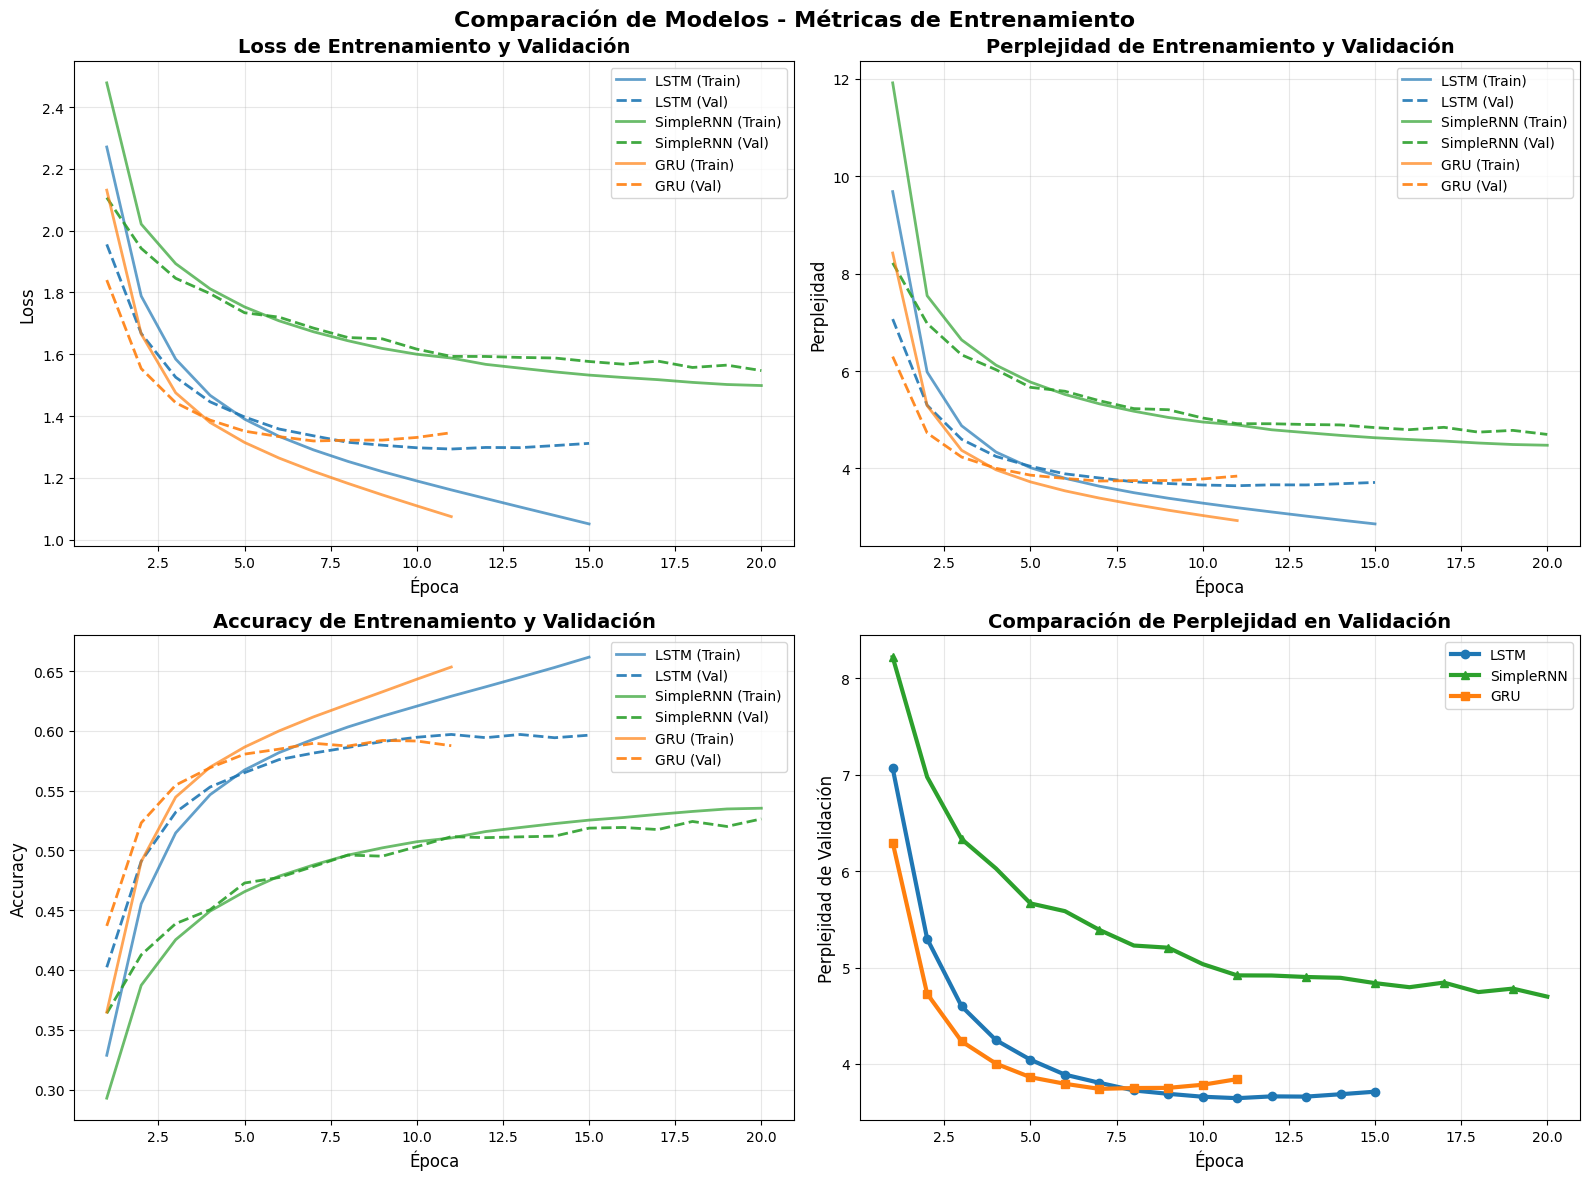


📋 RESUMEN FINAL DE MODELOS
Modelo          Best Val Loss   Best Val Perplexity  Best Val Accuracy   
--------------------------------------------------------------------------------
LSTM            1.2935          3.6455               0.5970              
SimpleRNN       1.5473          4.6989               0.5263              
GRU             1.3196          3.7418               0.5920              


In [ ]:
import matplotlib.pyplot as plt
import pickle

# Cargar historiales
print("Cargando historiales...")
with open('training_histories.pkl', 'rb') as f:
    histories = pickle.load(f)

print(f"Historiales cargados para: {list(histories.keys())}")

# ==========================================
# CONFIGURACIÓN DE GRÁFICOS
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos - Métricas de Entrenamiento', fontsize=16, fontweight='bold')

# Colores para cada modelo
colors = {'LSTM': '#1f77b4', 'GRU': '#ff7f0e', 'SimpleRNN': '#2ca02c'}
markers = {'LSTM': 'o', 'GRU': 's', 'SimpleRNN': '^'}

# ==========================================
# 1. LOSS (Train vs Validation)
# ==========================================
ax1 = axes[0, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['loss']) + 1)
    ax1.plot(epochs, history['loss'], 
             label=f'{model_name} (Train)', 
             color=colors[model_name], 
             linewidth=2, 
             alpha=0.7)
    ax1.plot(epochs, history['val_loss'], 
             label=f'{model_name} (Val)', 
             color=colors[model_name], 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# ==========================================
# 2. PERPLEJIDAD (Train vs Validation)
# ==========================================
ax2 = axes[0, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['train_perplexity']) + 1)
    ax2.plot(epochs, history['train_perplexity'], 
             label=f'{model_name} (Train)', 
             color=colors[model_name], 
             linewidth=2,
             alpha=0.7)
    ax2.plot(epochs, history['val_perplexity'], 
             label=f'{model_name} (Val)', 
             color=colors[model_name], 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Perplejidad', fontsize=12)
ax2.set_title('Perplejidad de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# ==========================================
# 3. ACCURACY (Train vs Validation)
# ==========================================
ax3 = axes[1, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    ax3.plot(epochs, history['accuracy'], 
             label=f'{model_name} (Train)', 
             color=colors[model_name], 
             linewidth=2,
             alpha=0.7)
    ax3.plot(epochs, history['val_accuracy'], 
             label=f'{model_name} (Val)', 
             color=colors[model_name], 
             linewidth=2, 
             linestyle='--',
             alpha=0.9)

ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(True, alpha=0.3)

# ==========================================
# 4. PERPLEJIDAD DE VALIDACIÓN (Comparación)
# ==========================================
ax4 = axes[1, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['val_perplexity']) + 1)
    ax4.plot(epochs, history['val_perplexity'], 
             label=model_name, 
             color=colors[model_name], 
             linewidth=3,
             marker=markers[model_name],
             markersize=6,
             markevery=max(1, len(epochs)//10))

ax4.set_xlabel('Época', fontsize=12)
ax4.set_ylabel('Perplejidad de Validación', fontsize=12)
ax4.set_title('Comparación de Perplejidad en Validación', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
print("\nGráfico guardado como 'training_metrics.png'")
plt.show()

# ==========================================
# 5. TABLA RESUMEN
# ==========================================
print("\n" + "="*80)
print("RESUMEN FINAL DE MODELOS")
print("="*80)
print(f"{'Modelo':<15} {'Best Val Loss':<15} {'Best Val Perplexity':<20} {'Best Val Accuracy':<20}")
print("-"*80)

for model_name, history in histories.items():
    best_val_loss = min(history['val_loss'])
    best_val_perp = min(history['val_perplexity'])
    best_val_acc = max(history['val_accuracy'])
    
    print(f"{model_name:<15} {best_val_loss:<15.4f} {best_val_perp:<20.4f} {best_val_acc:<20.4f}")

print("="*80)

In [ ]:
import os
import site

def configurar_gpu():
    """
    Configura las variables de entorno para que TensorFlow encuentre
    las librerías de NVIDIA instaladas via pip.
    """
    try:
        # 1. Localizar dónde instaló pip los paquetes
        site_packages = site.getsitepackages()[0]
        nvidia_path = os.path.join(site_packages, 'nvidia')
        
        if not os.path.exists(nvidia_path):
            print(f"No se encontró la carpeta 'nvidia' en {site_packages}")
            return

        # 2. Lista de librerías clave (cudnn, cublas, etc.)
        # Buscamos recursivamente carpetas 'lib' o 'lib64'
        cuda_lib_paths = []
        for root, dirs, files in os.walk(nvidia_path):
            if 'lib' in dirs:
                cuda_lib_paths.append(os.path.join(root, 'lib'))
            if 'lib64' in dirs:
                cuda_lib_paths.append(os.path.join(root, 'lib64'))

        # Eliminar duplicados
        cuda_lib_paths = list(set(cuda_lib_paths))

        # 3. Inyectar en LD_LIBRARY_PATH
        current_ld = os.environ.get('LD_LIBRARY_PATH', '')
        new_ld = current_ld + ':' + ':'.join(cuda_lib_paths)
        os.environ['LD_LIBRARY_PATH'] = new_ld
        
        print(f"Rutas de NVIDIA configuradas. Se añadieron {len(cuda_lib_paths)} rutas.")

    except Exception as e:
        print(f"Error configurando rutas: {e}")

# --- EJECUTAR LA CONFIGURACIÓN ---
configurar_gpu()

# --- AHORA SÍ, IMPORTAR TENSORFLOW ---
import tensorflow as tf

# --- VERIFICACIÓN FINAL ---
print("\nBuscando GPUs...")
gpus = tf.config.list_physical_devices()

if gpus:
    print(f"GPU DETECTADA: {gpus[0]}")
    print("   Ahora puedes usar el código 'Turbo' (Batch Size 2048).")
else:
    print("TensorFlow sigue sin ver la GPU. Probablemente requiere reinicio del kernel o hay conflicto de drivers del sistema.")

✅ Rutas de NVIDIA configuradas. Se añadieron 12 rutas.

🔍 Buscando GPUs...
🎉 ¡BINGO! GPU DETECTADA: PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
   Ahora puedes usar el código 'Turbo' (Batch Size 2048).


In [11]:
# Guarda esto como "donde_esta_cuda.py" y ejecútalo
import os
import site

try:
    site_packages = site.getsitepackages()[0]
    base_path = os.path.join(site_packages, 'nvidia')
    
    cudnn_lib = os.path.join(base_path, 'cudnn', 'lib')
    cublas_lib = os.path.join(base_path, 'cublas', 'lib')
    cudart_lib = os.path.join(base_path, 'cuda_runtime', 'lib') # A veces cambia el nombre
    
    print("\n--- COPIA Y PEGA ESTO EN TU TERMINAL ---")
    print(f"export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:{base_path}/cudnn/lib:{base_path}/cublas/lib:{base_path}/cuda_runtime/lib:{base_path}/cufft/lib:{base_path}/curand/lib:{base_path}/cusolver/lib:{base_path}/cusparse/lib:{base_path}/nccl/lib")
    print("----------------------------------------\n")
    
except Exception as e:
    print(e)


--- COPIA Y PEGA ESTO EN TU TERMINAL ---
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cudnn/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cublas/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cuda_runtime/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cufft/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/curand/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cusolver/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/cusparse/lib:/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/nvidia/nccl/lib
----------------------------------------



In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model

# ==========================================
# 1. CARGAR MODELO Y METADATOS
# ==========================================
print("Cargando modelo y diccionarios...")

# Cargar el modelo entrenado (puedes cambiar 'GRU' por 'LSTM' o 'SimpleRNN')
MODEL_NAME = 'LSTM'
model = load_model(f'model_{MODEL_NAME}.keras')

# Cargar metadatos del tokenizador
with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    char_to_int = meta['char_to_int']
    int_to_char = meta['int_to_char']
    vocab_size = meta['vocab_size']
    sequence_length = meta['sequence_length']

print(f"Modelo {MODEL_NAME} cargado.")
print(f"   Longitud de secuencia: {sequence_length}")
print(f"   Vocabulario: {vocab_size} caracteres")

# ==========================================
# 2. FUNCIONES DE GENERACIÓN
# ==========================================

def prepare_seed(text_seed):
    """Convierte una frase inicial en formato numérico."""
    text_seed = text_seed.lower()
    # Si es más corta que sequence_length, la rellenamos con espacios
    if len(text_seed) < sequence_length:
        text_seed = ' ' * (sequence_length - len(text_seed)) + text_seed
    # Si es más larga, tomamos solo los últimos caracteres
    elif len(text_seed) > sequence_length:
        text_seed = text_seed[-sequence_length:]
    
    # Convertir a integers
    pattern = [char_to_int.get(c, char_to_int[' ']) for c in text_seed]
    return pattern

def greedy_search(seed_text, n_chars=200):
    """Genera texto eligiendo siempre el carácter más probable."""
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        result = int_to_char[index]
        generated += result
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def sample_with_temperature(seed_text, n_chars=200, temperature=1.0):
    """Genera texto usando muestreo con temperatura."""
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)[0]
        
        # Aplicar temperatura
        prediction = np.log(prediction + 1e-10) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        
        # Muestrear según las probabilidades
        index = np.random.choice(len(prediction), p=prediction)
        result = int_to_char[index]
        generated += result
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def beam_search(seed_text, n_chars=200, beam_width=3):
    """Genera texto usando beam search."""
    pattern = prepare_seed(seed_text)
    
    # Inicializar: cada beam es (secuencia, probabilidad_acumulada, patrón)
    beams = [(seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text, 
              0.0, 
              pattern.copy())]
    
    for _ in range(n_chars):
        candidates = []
        
        for seq, score, pat in beams:
            x = np.reshape(pat, (1, sequence_length))
            prediction = model.predict(x, verbose=0)[0]
            
            # Obtener los top-k candidatos
            top_indices = np.argsort(prediction)[-beam_width:]
            
            for idx in top_indices:
                new_seq = seq + int_to_char[idx]
                new_score = score + np.log(prediction[idx] + 1e-10)
                new_pat = pat.copy()
                new_pat.append(idx)
                new_pat = new_pat[1:]
                candidates.append((new_seq, new_score, new_pat))
        
        # Seleccionar los mejores beam_width candidatos
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    
    # Retornar el mejor
    return beams[0][0]

print("\nFunciones de generación listas para usar.")

2025-11-25 11:10:23.702586: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


📂 Cargando modelo y diccionarios...


I0000 00:00:1764079826.151920    9946 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22122 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:09:00.0, compute capability: 8.6


✅ Modelo LSTM cargado.
   Longitud de secuencia: 100
   Vocabulario: 99 caracteres

✅ Funciones de generación listas para usar.


/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# ==========================================
# 3. ¡PRUEBA TU FRASE AQUÍ!
# ==========================================

# Cambia esta frase por lo que quieras
FRASE_INICIAL = "Sancho Panz"

# Número de caracteres a generar
N_CARACTERES = 50

print("=" * 80)
print(f"FRASE INICIAL: '{FRASE_INICIAL}'")
print("=" * 80)

# ==========================================
# GREEDY SEARCH (Más determinístico)
# ==========================================
print("\nGREEDY SEARCH:")
print("-" * 80)
resultado_greedy = greedy_search(FRASE_INICIAL, N_CARACTERES)
print(resultado_greedy)

# ==========================================
# BEAM SEARCH (Explora más posibilidades)
# ==========================================
print("\n\nBEAM SEARCH (beam_width=5):")
print("-" * 80)
resultado_beam = beam_search(FRASE_INICIAL, N_CARACTERES, beam_width=5)
print(resultado_beam)

# ==========================================
# SAMPLING CON DIFERENTES TEMPERATURAS
# ==========================================
temperaturas = [0.5, 1.0, 1.5]

for temp in temperaturas:
    print(f"\n\nSAMPLING (temperatura={temp}):")
    print("-" * 80)
    resultado_temp = sample_with_temperature(FRASE_INICIAL, N_CARACTERES, temperature=temp)
    print(resultado_temp)

print("\n" + "=" * 80)
print("Generación completada. Cambia FRASE_INICIAL para probar otras frases.")
print("=" * 80)

🌱 FRASE INICIAL: 'Sancho Panz'

🎯 GREEDY SEARCH:
--------------------------------------------------------------------------------


2025-11-25 11:10:28.330179: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


Sancho Panza, y con esta casa de mi padre le dio a mi padre, 


🔦 BEAM SEARCH (beam_width=5):
--------------------------------------------------------------------------------
Sancho Panza, que no me parece que no me acuerdo de manera qu


🌡️ SAMPLING (temperatura=0.5):
--------------------------------------------------------------------------------
Sancho Panza, que no me parece que no me acuerdo de manera qu


🌡️ SAMPLING (temperatura=0.5):
--------------------------------------------------------------------------------
Sancho Panza, y como se la ha encantado de mi padre. — con to


🌡️ SAMPLING (temperatura=1.0):
--------------------------------------------------------------------------------
Sancho Panza, y como se la ha encantado de mi padre. — con to


🌡️ SAMPLING (temperatura=1.0):
--------------------------------------------------------------------------------
Sancho Panza de tu burcadura. la presencia que te reino, y to


🌡️ SAMPLING (temperatura=1.5):
--------------------------